**Filtering a real sound signal using SVD**



In [ ]:
#Importing necessary libraries
import numpy as np   #For mathemattical and linear algebra opeerations
import matplotlib.pyplot as plt  #For plotting different graphs
from scipy.io import wavfile    #For uploading and reading the audio file
from IPython.display import Audio  #This function serves for reading the audio file

In [ ]:
path='../data/1.wav'

In [ ]:
#Uploading the audioi file
fs ,  s=wavfile.read(path)  #fs is the sampling frequency, while s is the audio signal uploaded

In [ ]:
#Checking if it is stereo on mono
if s.ndim > 1:
  s=s[: , 0]   #Only keeping one channel, which is very important for SVD analysis

In [ ]:
#Normalization and determination of time domain
t=np.linspace(0 , len(s)/fs, len(s))
s_normalized=s/np.max(np.abs(s))  #Normalization of the signal to ensure compatibility with audio and other processing libraries

In [ ]:
#Playing the audio file
Audio(s_normalized, rate=fs)

In [22]:
#Creation of a function that creates Hankel matrix
from scipy.linalg import hankel
def hankel_matrix(s, window_size):
  s=np.asarray(s)   #s must be a Numpy array, not a python list
  N=len(s)
  if s.ndim > 1:
    raise ValueError("Signal must be 1D array")  #s must be 1D numpy array
  if window_size > N or window_size < 2:
    raise ValueError("window size must be less than signal length and bigger than one")
  expected_shape=(window_size, N-window_size+1)
  H=hankel(s[:window_size], s[window_size-1:])
  if H.shape != expected_shape:
    raise ValueError(f"hankel matrix shape mismatch: expected:{expected_shape}, got:{H.shape}")
  return H

In [ ]:
#Hnakel matrix creation
H=hankel_matrix(s_normalized, window_size=100)  #Because of RAM capacities, I arbitrary chose window size=100, in practice, window size usually is in range of often N/5 to N/2

In [23]:
#Singular values decomposition of the hankel matrix
U, sigma, Vt=np.linalg.svd(H , full_matrices=False)

In [24]:
#Choosing the rank based on the energy criterion
def r_choose(sigma, threshold):
  sigma=np.asarray(sigma)
  if sigma.ndim > 1:
    raise ValueError("sigma should be a iD numpy array")
  E_t=np.sum(sigma**2)    #Computing the total energy in the signal
  E=0   #Initializing cumulative energy sum of singular values
  for i in range(len(sigma)):
    E+=sigma[i]**2  #Accumulating energy at each iteration
    if E/E_t >= threshold:
      break    # Stop when cumulative energy reaches desired threshold of total energy
  r=i+1
  return r    #Returning optimal rank where the desired threshold is reached


In [27]:
r_1= r_choose(sigma, threshold=0.80)
print(r_1)

4


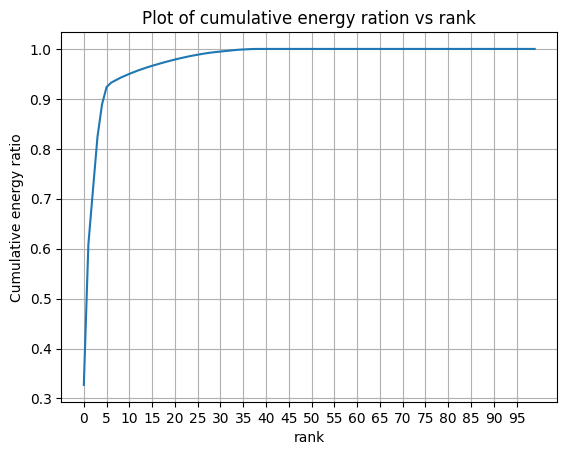

In [28]:
#Choosing the rank visually
energy=sigma**2  #Calculating energy of each singular component
cumulative_energy_ratio=np.cumsum(energy)/np.sum(energy)   #Computing cimulative energy ratio
plt.figure()
plt.plot(cumulative_energy_ratio)
plt.xticks(np.arange(0 , 100, 5))
plt.xlabel('rank')
plt.ylabel("Cumulative energy ratio")
plt.title("Plot of cumulative energy ration vs rank")
plt.grid(True)

By visual inspection of the cumulative energy curve, we observe that up to r = 30, the cumulative energy ratio increases significantly. This indicates that each additional singular value contributes meaningful energy and therefore carries useful information about the signal.

After r = 30, the cumulative energy curve becomes almost flat, meaning that the remaining singular values contribute very little energy. Consequently, they do not add significant information and are likely dominated by noise.

Based on this analysis, we choose r = 30 as the optimal rank for SVD reconstruction, as it captures the majority of the signal energy while excluding the low-energy, noise-dominated components.

In [33]:
r=30   #The optimal rank that conserves most of the energy present in the signal
#Keeping only high energy components
U_r=U[: , :r]   #Only keeping top r left singular vectors
sigma_r=sigma[:r]  #Only keeping top r singular values
Vt_r=Vt[:r , :]  #Only keeping top r right singular vectors

In [30]:
#Reconstruction of the hankel matrix
H_r=U_r@np.diag(sigma_r)@Vt_r

In [35]:
#Definition of a function that reconstructs filtrered signal
def reconstruct_from_hankel_matrix(H):
  r , c =H.shape    #Determining the shape of the hankel matrix in order to defining the dimensions of the filtered signal
  denoised=np.zeros(r+c-1)   # # Initialize output signal array
  counts=np.zeros(r+c-1)   #To count the number of elements per anti-diagonal
  for i in range (r):   #construction the denoised (filtered) signal
    for j in range(c):
      denoised[i+j]+=H[i , j]
      counts[i+j]+=1
  return denoised/counts

In [36]:
filtered_signal=reconstruct_from_hankel_matrix(H_r)

In [37]:
#Playing the filtered signal
Audio(filtered_signal, rate=fs)

In [49]:
#Computing the fourier transform of the original and filtered signals
fft_filtered=np.fft.fft(filtered_signal)   #Fourier transform of the filtered signal
fft_noisy=np.fft.fft(s_normalized)   #Fourier transform of the original""noisy"" signal
freq=np.fft.fftfreq(len(fft_filtered), d=t[1]-t[0]) #Frequency band

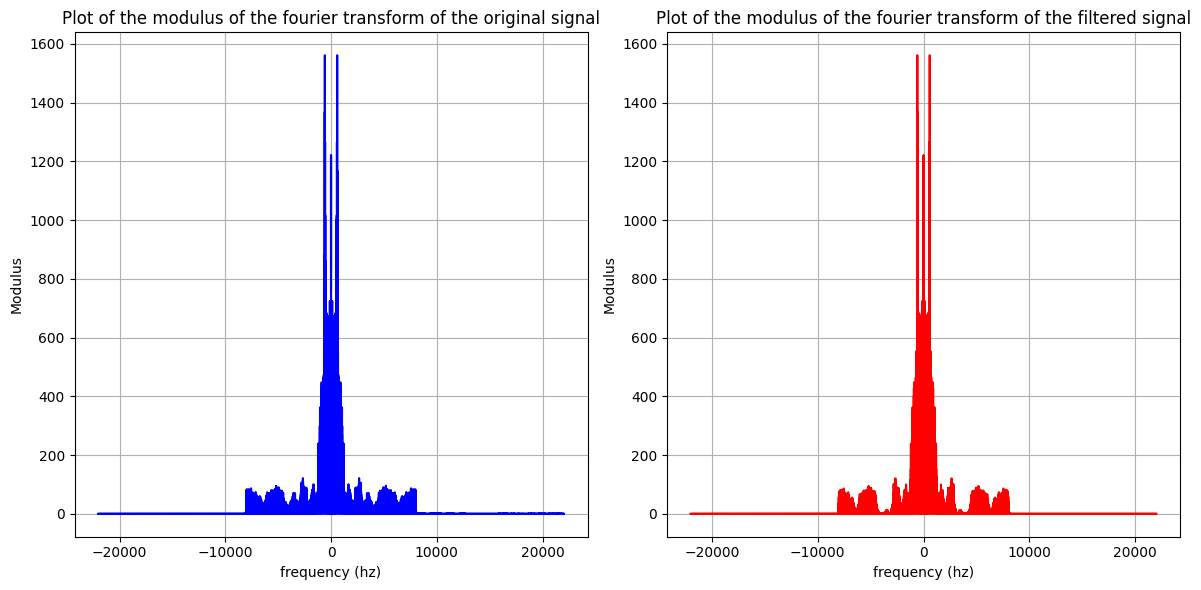

In [50]:
#Plotting the modulus of the fourier transforms
plt.figure(figsize=(12 , 6))
plt.subplot(1 , 2 , 1)
plt.plot(freq, np.abs(fft_noisy), color='b')
plt.xlabel('frequency (hz)')
plt.ylabel('Modulus')
plt.title('Plot of the modulus of the fourier transform of the original signal')
plt.grid(True)
plt.subplot(1 , 2 , 2)
plt.plot(freq, np.abs(fft_filtered), color='r')
plt.xlabel('frequency (hz)')
plt.ylabel('Modulus')
plt.title('Plot of the modulus of the fourier transform of the filtered signal')
plt.grid(True)
plt.tight_layout()

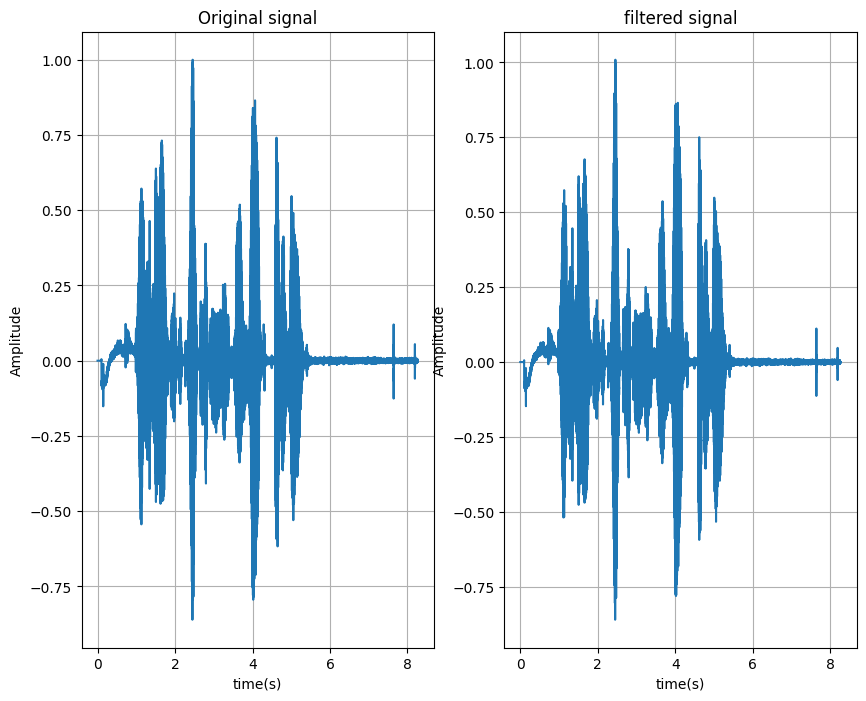

In [40]:
#Plotting orignal and filtered signals
plt.figure(figsize=(10 , 8))
plt.subplot(1 , 2 , 1)
plt.plot(t , s_normalized)
plt.xlabel('time(s)')
plt.ylabel('Amplitude')
plt.title('Original signal')
plt.grid(True)
plt.subplot(1  ,2 , 2)
plt.plot(t , filtered_signal)
plt.xlabel('time(s)')
plt.ylabel('Amplitude')
plt.title('filtered signal')
plt.grid(True)

In [52]:
#Signal to ratio estimation
estimated_snr=10*np.log10(np.sum(filtered_signal**2)/(np.sum((filtered_signal-s_normalized)**2))) #This a blind SNR estimation
print(estimated_snr)

24.320124462633935


Since we do not have the clean pure audio file, we used the blind SNR estimation assuing that "filtered_signal-s_normalized" approximately gives noise.
An estimated SNR value of 24.32db is pretty good sign that the noise was substantially reduces compared to what was present  